In [1]:
#Instances locally converted to match Piesinger's format and uploaded to the folder "hardInstancesPI"
#As the process is almost identical to the Par10Solver, the code is almost identical as well
import random
import pandas as pd
import numpy as np
import os
import subprocess

In [2]:
#single run, to change the directory; necessary to perform commandline actions
os.chdir("knapsacksolver")

In [ ]:
#only needed if cell above ran multiple times, undo action
os.chdir("..")

In [3]:
#Similar to FinalizeInstances, Functions to read the maximum profit and necessary time
#Standard Values of no solution was found: max_profit = 0, time = 50000 (time will be overwritten later)
def read_max_profit(string):
    string = string[string.find("Value"):]
    string= string[:string.find("\\n")]
    if string == "":
        return 0
    else: 
        string = int(string[6:])
        return string

def read_time(string):
    string = string[string.find("Time"):]
    string = string[:string.find("\\n")]
    if string == "":
        return 50000
    else: 
        string = round(float(string[10:]),2)
        return string
    return string

#Funtion to perform the commandline command
def solve_profit_time(filepath, algorithm, time_limit, seed, scores):
    solution = subprocess.run(["./bazel-bin/knapsacksolver/main -v 1 --algorithm "+str(algorithm)+" --input " + str(filepath) + " --time-limit "+str(time_limit)+" --seed "+str(seed)+" --format pisinger"], shell=True, capture_output=True)
    solution = str(solution.stdout)
    profit = read_max_profit(solution)
    time = read_time(solution)
    return(profit, time)

In [5]:
#Identical to the Par10Solver
#Function to compare the solution with the optimal solution and returning the time accordingly
def calculate_score(filepath, scores, profit, time, time_limit):
    with open(filepath) as file:
        lines = file.readlines()
    max_profit_line = lines[3]
    max_profit = int(max_profit_line[2:])
    if profit == max_profit:
        time = time
    else: time = time_limit * 1000 * 10 #time_limit in s, time in ms
    newrow = pd.DataFrame({"time": [time]}, index=[filepath])
    scores = pd.concat([scores, newrow])
    return scores

In [6]:
time_limit = 10 #in seconds

#Function for parallel calculation
def parallel(seed):    
    for algorithm in ["greedy", "dynamic_programming_bellman_array", "branch_and_bound_sort"]:
        scores = pd.DataFrame(columns=["time"])
        for filename in os.listdir("hardInstancesPI/"):
            if ".csv" in filename:
                filepath = "hardInstancesPI/"+filename
                profit, time = solve_profit_time(filepath, algorithm, time_limit, seed, scores)
                scores = calculate_score(filepath, scores, profit, time, time_limit)
        scores.to_csv("hardInstancesScores/scores_"+str(algorithm)+"_"+str(seed)+".csv", index=True, sep=",", header=True, index_label=None)

In [7]:
#(Parallel) Calculation of the score of a single run that will create 1 csv file per algorithm in folder hardInstancesScores
from joblib import Parallel, delayed
Parallel(n_jobs=8)(delayed(parallel)(i) for i in range(1))

[None]

In [22]:
import pandas as pd
import os
#Concat scores, as it was only a single run, no average needs to be calculated
score_path = "knapsacksolver/hardInstancesScores/"
hard_scores = pd.DataFrame()
for filename in os.listdir(score_path): #List all scores
    if "hard" in filename: #Exclude the combined file
        continue
    solver = filename[7:-6] #remove the 7 first and 6 last symbols from the filename: "scores_..._0.csv"
    filepath = score_path + filename
    algorithm_results = pd.DataFrame(pd.read_csv(filepath, header=0, index_col=0))
    algorithm_results.columns = [solver] #Set the columnname
    
    #Append the combined file with the algorithm
    hard_scores = pd.concat([hard_scores, algorithm_results], axis = 1, join="outer", sort=True)

#Rename columns and save the file as "hardInstancesScores/hard_scores"
hard_scores = hard_scores.rename(columns={"dynamic_programming_bellman_array":"dynamic_programming", "branch_and_bound_sort": "branch_and_bound"})
hard_scores.to_csv("knapsacksolver/hardInstancesScores/hard_scores.csv", index=True, sep=",", header=True, index_label=None)

In [45]:
#Amount of solved instances, where the score is not 100,000
amount_solved = hard_scores.copy()
amount_solved["at_least_one_algorithm"] = amount_solved.min(axis=1)
for column in amount_solved.columns:
    count = amount_solved[column][amount_solved[column] != 100000].count()
    print(str(column)+" solved " + str(count) + " instances")

dynamic_programming solved 216 instances
greedy solved 1 instances
branch_and_bound solved 89 instances
at_least_one_algorithm solved 227 instances


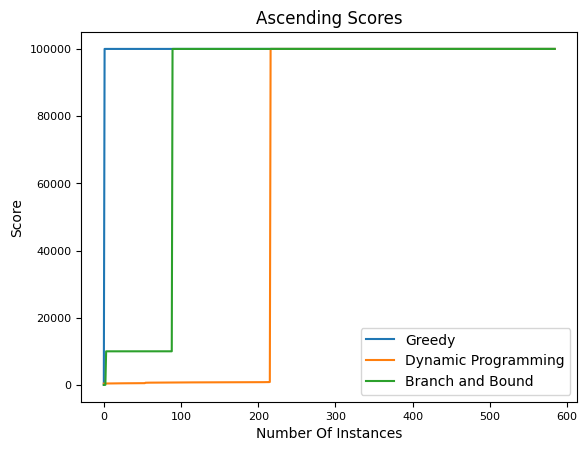

In [37]:
import matplotlib.pyplot as plt
#Same graph as in ScoreOverview.ipynb to illustrate the performance of the algorithms

#Sort each algorithm individually and reset the index
greedy = pd.DataFrame(hard_scores["greedy"])
greedy = greedy.sort_values("greedy", ascending=True)
greedy = greedy.reset_index(drop=True)
dynamic_programming = pd.DataFrame(hard_scores["dynamic_programming"])
dynamic_programming = dynamic_programming.sort_values("dynamic_programming", ascending=True)
dynamic_programming = dynamic_programming.reset_index(drop=True)
branch_and_bound = pd.DataFrame(hard_scores["branch_and_bound"])
branch_and_bound = branch_and_bound.sort_values("branch_and_bound", ascending=True)
branch_and_bound = branch_and_bound.reset_index(drop=True)

#Plot the three algortihms in the same plot
plt.plot(greedy, label="Greedy")
plt.plot(dynamic_programming, label="Dynamic Programming")
plt.plot(branch_and_bound, label="Branch and Bound")

#Set title and labels
plt.xlabel("Number Of Instances", fontsize=10)
plt.ylabel("Score", fontsize=10)
plt.title("Ascending Scores", fontsize=12)

#Set font size for axis notations
plt.gca().tick_params(axis='both', which='major', labelsize=8)

#Add the legend
plt.legend()

plt.rcParams['savefig.dpi'] = 1000 #Increase the resolution for a png file (not used here as it is saved as pdf)
plt.savefig("figures/hard_ascending_scores.pdf") #Save the figure in "figures"
plt.show()

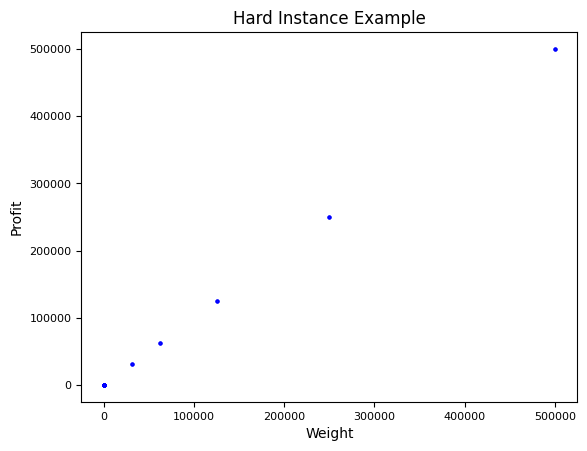

In [44]:
#Graph to illustrate an instance of the hard instances
#Functions already used
def read_profit(line):
    line = str(line)
    line = line[(line.find(",")+1):]
    line = line[:line.find(",")]
    return int(line)

def read_weight(line):
    line = str(line)
    line = line[(line.find(",")+1):]
    line = line[(line.find(",")+1):]
    line = line[:line.find(",")]
    return int(line)

def build_items(items):
    for index in items.index:
        profit = read_profit(items[0][index])
        weight = read_weight(items[0][index])
        items.at[index, "profit"] = profit
        items.at[index, "weight"] = weight
    return pd.concat([items["profit"], items["weight"]], axis=1)

#Very similar to the overview of the generation rules
file = "n_1000_c_1000000_g_6_f_0.3_eps_1e-05_s_100.csv" #Example file, no major differences across the instances
with open("knapsacksolver/hardInstancesPI/"+file) as file:
    lines = file.readlines()
items = pd.DataFrame(lines[5:])
items = build_items(items)

#Plot the points with very low alpha but a size increase
plt.scatter(items["weight"], items["profit"], alpha = 0.01, color="b", s=5)

#Set title and label
plt.xlabel("Weight", fontsize=10)
plt.ylabel("Profit", fontsize=10)
plt.title("Hard Instance Example", fontsize=12)

#Set font size for axis notations
plt.gca().tick_params(axis='both', which='major', labelsize=8)

plt.rcParams['savefig.dpi'] = 1000
plt.savefig("figures/hard_instance.pdf") #Save as pdf
plt.show()